In [1]:
import numpy as np
import cv2
import os

class EASTDetector:
    def __init__(self, small_overlap = 0.1, large_overlap = 0.9, horizontal_padding=0, vertical_padding=50):
        assert small_overlap < large_overlap, "Small Overlap must be smaller than Large Overlap"
        assert large_overlap < 1 and small_overlap > 0, "Large and Small overlap must be between 0 and 1"

        self.small_overlap = small_overlap
        self.large_overlap = large_overlap
        self.vertical_padding = vertical_padding
        self.horizontal_padding = horizontal_padding

    def non_max_suppression_fast(self, boxes, overlapThresh, merge):
        """
        Modified Non-maximal Suppression to condense the number of bounding boxes.
        Modified from https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
        Parameters:
        - Boxes: 2D numpy array. Each entry represents a bounding box (minX, minY, maxX, maxY)
        - Overlap Threshold: The percentage of area overlap required to consider two boxes the same
        - Merge: Suppress boxes into a larger, merged box (modified non-max-suppression) or into the left most box (traditional non-max-suppression)
        """
        # if there are no boxes, return an empty list
        if len(boxes) == 0:
            return []

        # if the bounding boxes are integers, convert them to floats --
        # this is important since we'll be doing a bunch of divisions
        if boxes.dtype.kind == "i":
            boxes = boxes.astype("float")

        # initialize the list of picked indexes	
        pick = []

        # grab the coordinates of the bounding boxes
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]

        # compute the area of the bounding boxes and sort the bounding
        # boxes by the bottom-right y-coordinate of the bounding box
        # Add one because coordinates are zero-indexed
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(y2)

        # keep looping while some indexes still remain in the indexes
        # list
        while len(idxs) > 0:
            # grab the last index in the indexes list and add the
            # index value to the list of picked indexes
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = np.maximum(x1[i] - 100, x1[idxs[:last]])
            yy1 = np.maximum(y1[i], y1[idxs[:last]])
            xx2 = np.minimum(x2[i] + 100, x2[idxs[:last]])
            yy2 = np.minimum(y2[i], y2[idxs[:last]])

            # compute the width and height of the bounding box
            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            # compute the ratio of overlap
            overlap = (w * h) / area[idxs[:last]]
            
            overlapIdxs = np.concatenate(([last], np.where(overlap > overlapThresh)[0]))

            # delete all overlapping indices from the list
            idxs = np.delete(idxs, overlapIdxs)
            
            if merge and overlapIdxs.size != 0:        
                nx1 = np.min(x1[overlapIdxs])
                ny1 = np.min(y1[overlapIdxs])
                nx2 = np.max(x2[overlapIdxs])
                ny2 = np.max(y2[overlapIdxs])

                boxes[i, :] = np.array([nx1, ny1, nx2, ny2])
            
        # return only the bounding boxes that were picked using the
        # integer data type
        return boxes[pick].astype("int")

    def detect(self, image):
        """
        Retrives bounding boxes for detected text in an image
        The bounding boxes returned by the detector are slightly enlarged to ensure they capture all of the text
        Modified from https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
        """
        (originalH, originalW) = image.shape[:2]
 
        # set the new width and height and then determine the ratio in change
        # for both the width and height
        (newW, newH) = ((originalW // 32) * 32, (originalH // 32) * 32)
        rW = originalW / float(newW)
        rH = originalH / float(newH)

        # resize the image and grab the new image dimensions
        image = cv2.resize(image, (newW, newH))
        (H, W) = image.shape[:2]
        
        layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

        # construct a blob from the image and then perform a forward pass of
        # the model to obtain the two output layer sets
        blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
        net = cv2.dnn.readNet("frozen_east_text_detection.pb")
        net.setInput(blob)

        (scores, geometry) = net.forward(layerNames)
        
        (numRows, numCols) = scores.shape[2:4]
        rects = []
        confidences = []

        # loop over the number of rows
        for y in range(0, numRows):
            # extract the scores (probabilities), followed by the geometrical
            # data used to derive potential bounding box coordinates that
            # surround text
            scoresData = scores[0, 0, y]
            xData0 = geometry[0, 0, y]
            xData1 = geometry[0, 1, y]
            xData2 = geometry[0, 2, y]
            xData3 = geometry[0, 3, y]
            anglesData = geometry[0, 4, y]

            for x in range(0, numCols):
                # if our score does not have sufficient probability, ignore it
                if scoresData[x] < 0.5:
                    continue

                # compute the offset factor as our resulting feature maps will
                # be 4x smaller than the input image
                (offsetX, offsetY) = (x * 4.0, y * 4.0)

                # extract the rotation angle for the prediction and then
                # compute the sin and cosine
                angle = anglesData[x]
                cos = np.cos(angle)
                sin = np.sin(angle)

                # use the geometry volume to derive the width and height of
                # the bounding box
                h = xData0[x] + xData2[x]
                w = xData1[x] + xData3[x]

                # compute both the starting and ending (x, y)-coordinates for
                # the text prediction bounding box
                endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
                endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
                startX = int(endX - w)
                startY = int(endY - h)
                
                # add the bounding box coordinates and probability score to
                # our respective lists
                rects.append((startX, startY, endX, endY))
                confidences.append(scoresData[x])
        
        boxes = self.non_max_suppression_fast(np.array(rects), self.small_overlap, True)
        boxes = self.non_max_suppression_fast(boxes, self.large_overlap, False)

        finalBoxes = []
        # loop over the bounding boxes
        v_pad = self.vertical_padding // 2
        h_pad = self.horizontal_padding // 2

        for (startX, startY, endX, endY) in boxes:
            # scale the bounding box coordinates based on the respective ratios
            startX = max(int(startX * rW) - h_pad, 0)
            startY = max(int(startY * rH) - v_pad, 0)
            endX = min(int(endX * rW) + h_pad, originalW)
            endY = min(int(endY * rH) + v_pad, originalH)
            finalBoxes.append((startX, startY, endX, endY))

        return finalBoxes
    
    def get_slices(self, image):
        boxes = self.detect(image)
        book_slices = []
        for startX, startY, endX, endY in boxes:
            book_slice = image[startY:endY, startX:endX, :]
            book_slices.append(book_slice)
            
        return book_slices

In [10]:
import numpy as np
import pytesseract
import cv2
import matplotlib.pyplot as plt

In [11]:
east_detector = EASTDetector()

In [12]:
def load_image(name):
    image = cv2.imread(name)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [13]:
def show_images(images, cols=2, titles=None):
    assert titles is None or len(images) == len(titles)
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    fig.tight_layout()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        a.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [14]:
def narrow(image, convert_color = False, binarize = True):
    """
    Draws narrower bounding boxes by heavily dilating the image and picking out the 3 largest blocks
    """
    original = image.copy()
    if convert_color:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
    if binarize:            
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        if np.mean(image) > 127:
            binary = cv2.bitwise_not(image)
        
    box_kernel = np.ones((5, 25), np.uint8)
    dilation = cv2.dilate(image, box_kernel, iterations = 1)
    bounds, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []

    for cnt in bounds:
        x, y, w, h = cv2.boundingRect(cnt)
        region = original[y:y + h, x:x + w]
        boxes.append(region)

    boxes = sorted(boxes, key=lambda i: -1 * i.shape[0] * i.shape[1])
    return boxes[:3]

def narrow_images(images, convert_color=False, binarize=False):
    narrowed = []
    titles = []
    for img in images:
        regions = narrow(img, convert_color, binarize)
        for region in regions:
            narrowed.append(region)
    return narrowed

In [15]:
def binarize_images(images, black_on_white=False):
    binarized = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        if np.mean(binary) > 127:
            binary = cv2.bitwise_not(binary)
        
        binarized.append(binary)
    return binarized

In [16]:
def dilate_images(images, kernel = np.ones((1, 1), np.uint8), iterations=1):
    dilated = []
    for img in images:
        img_dilated = cv2.dilate(img, kernel, iterations=iterations)
        dilated.append(img_dilated)
    return dilated

In [17]:
def blur_images(images, blur_weight=1):
    blurred = []
    for dilated in images:
        img_blurred = cv2.medianBlur(dilated, blur_weight)
        blurred.append(img_blurred)
    return blurred

In [18]:
custom_config = r'-l eng+hin --psm 6'

img = load_image("test_1.jpg")
print(pytesseract.image_to_string(img, config=custom_config))

Es es 2##=> fers i = >
ri, f — = ae
COMET OEARTMENT कुडें 1
PAWAN KANSAL __ ट x =e: क
feo 2 ae 4 सट आथा ere
“ RAMESHWAR DASS KANSAL eae Ls
1210411966 a Sie .
Peptanent Account Number 35 न पध
श्रनाशागाद0574० क ni
ee aso. ©
आ क Eee 122 wed
Semele? ae Bie CSS
je Tce SE i ce



In [19]:
detector = EASTDetector()
slices = detector.get_slices(img)

C:\Users\asus\AppData\Local\Temp/ipykernel_13452/551261532.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


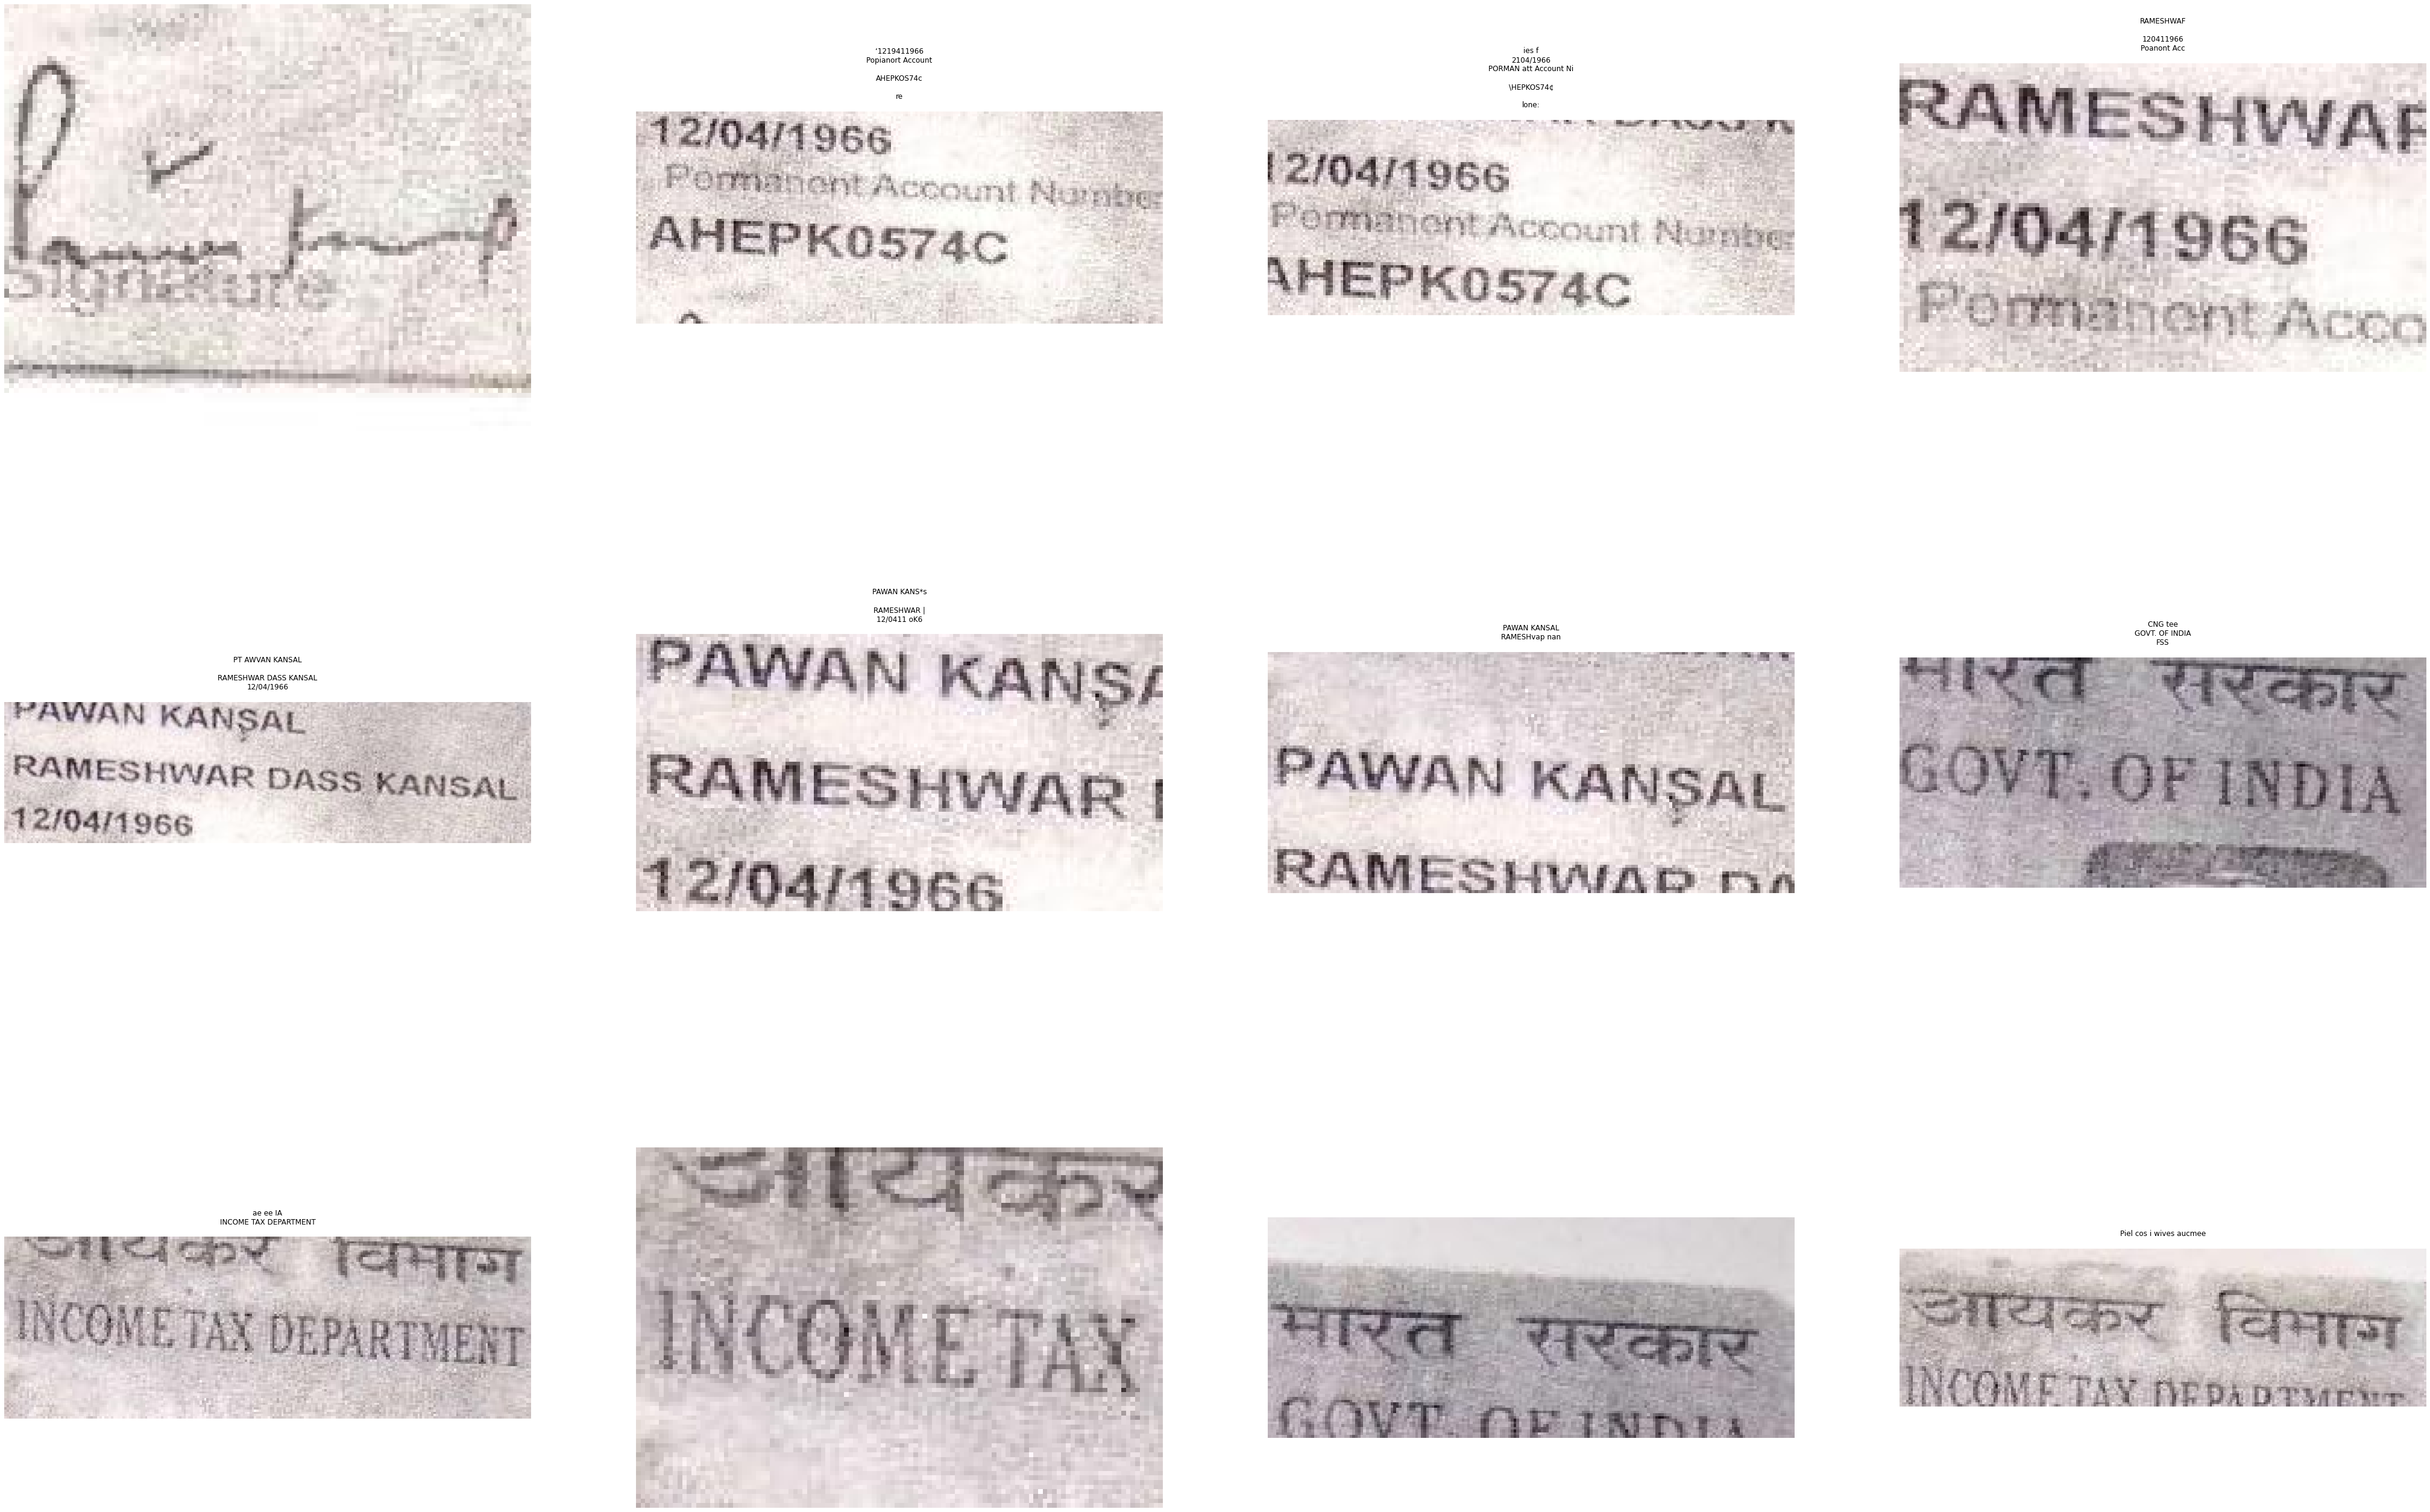

In [20]:
titles = [pytesseract.image_to_string(img) for img in slices]
show_images(slices, titles=titles, cols=3)

In [21]:
narrowed = binarize_images(slices[2:], black_on_white=False)
narrowed = narrow_images(narrowed)

C:\Users\asus\AppData\Local\Temp/ipykernel_13452/551261532.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


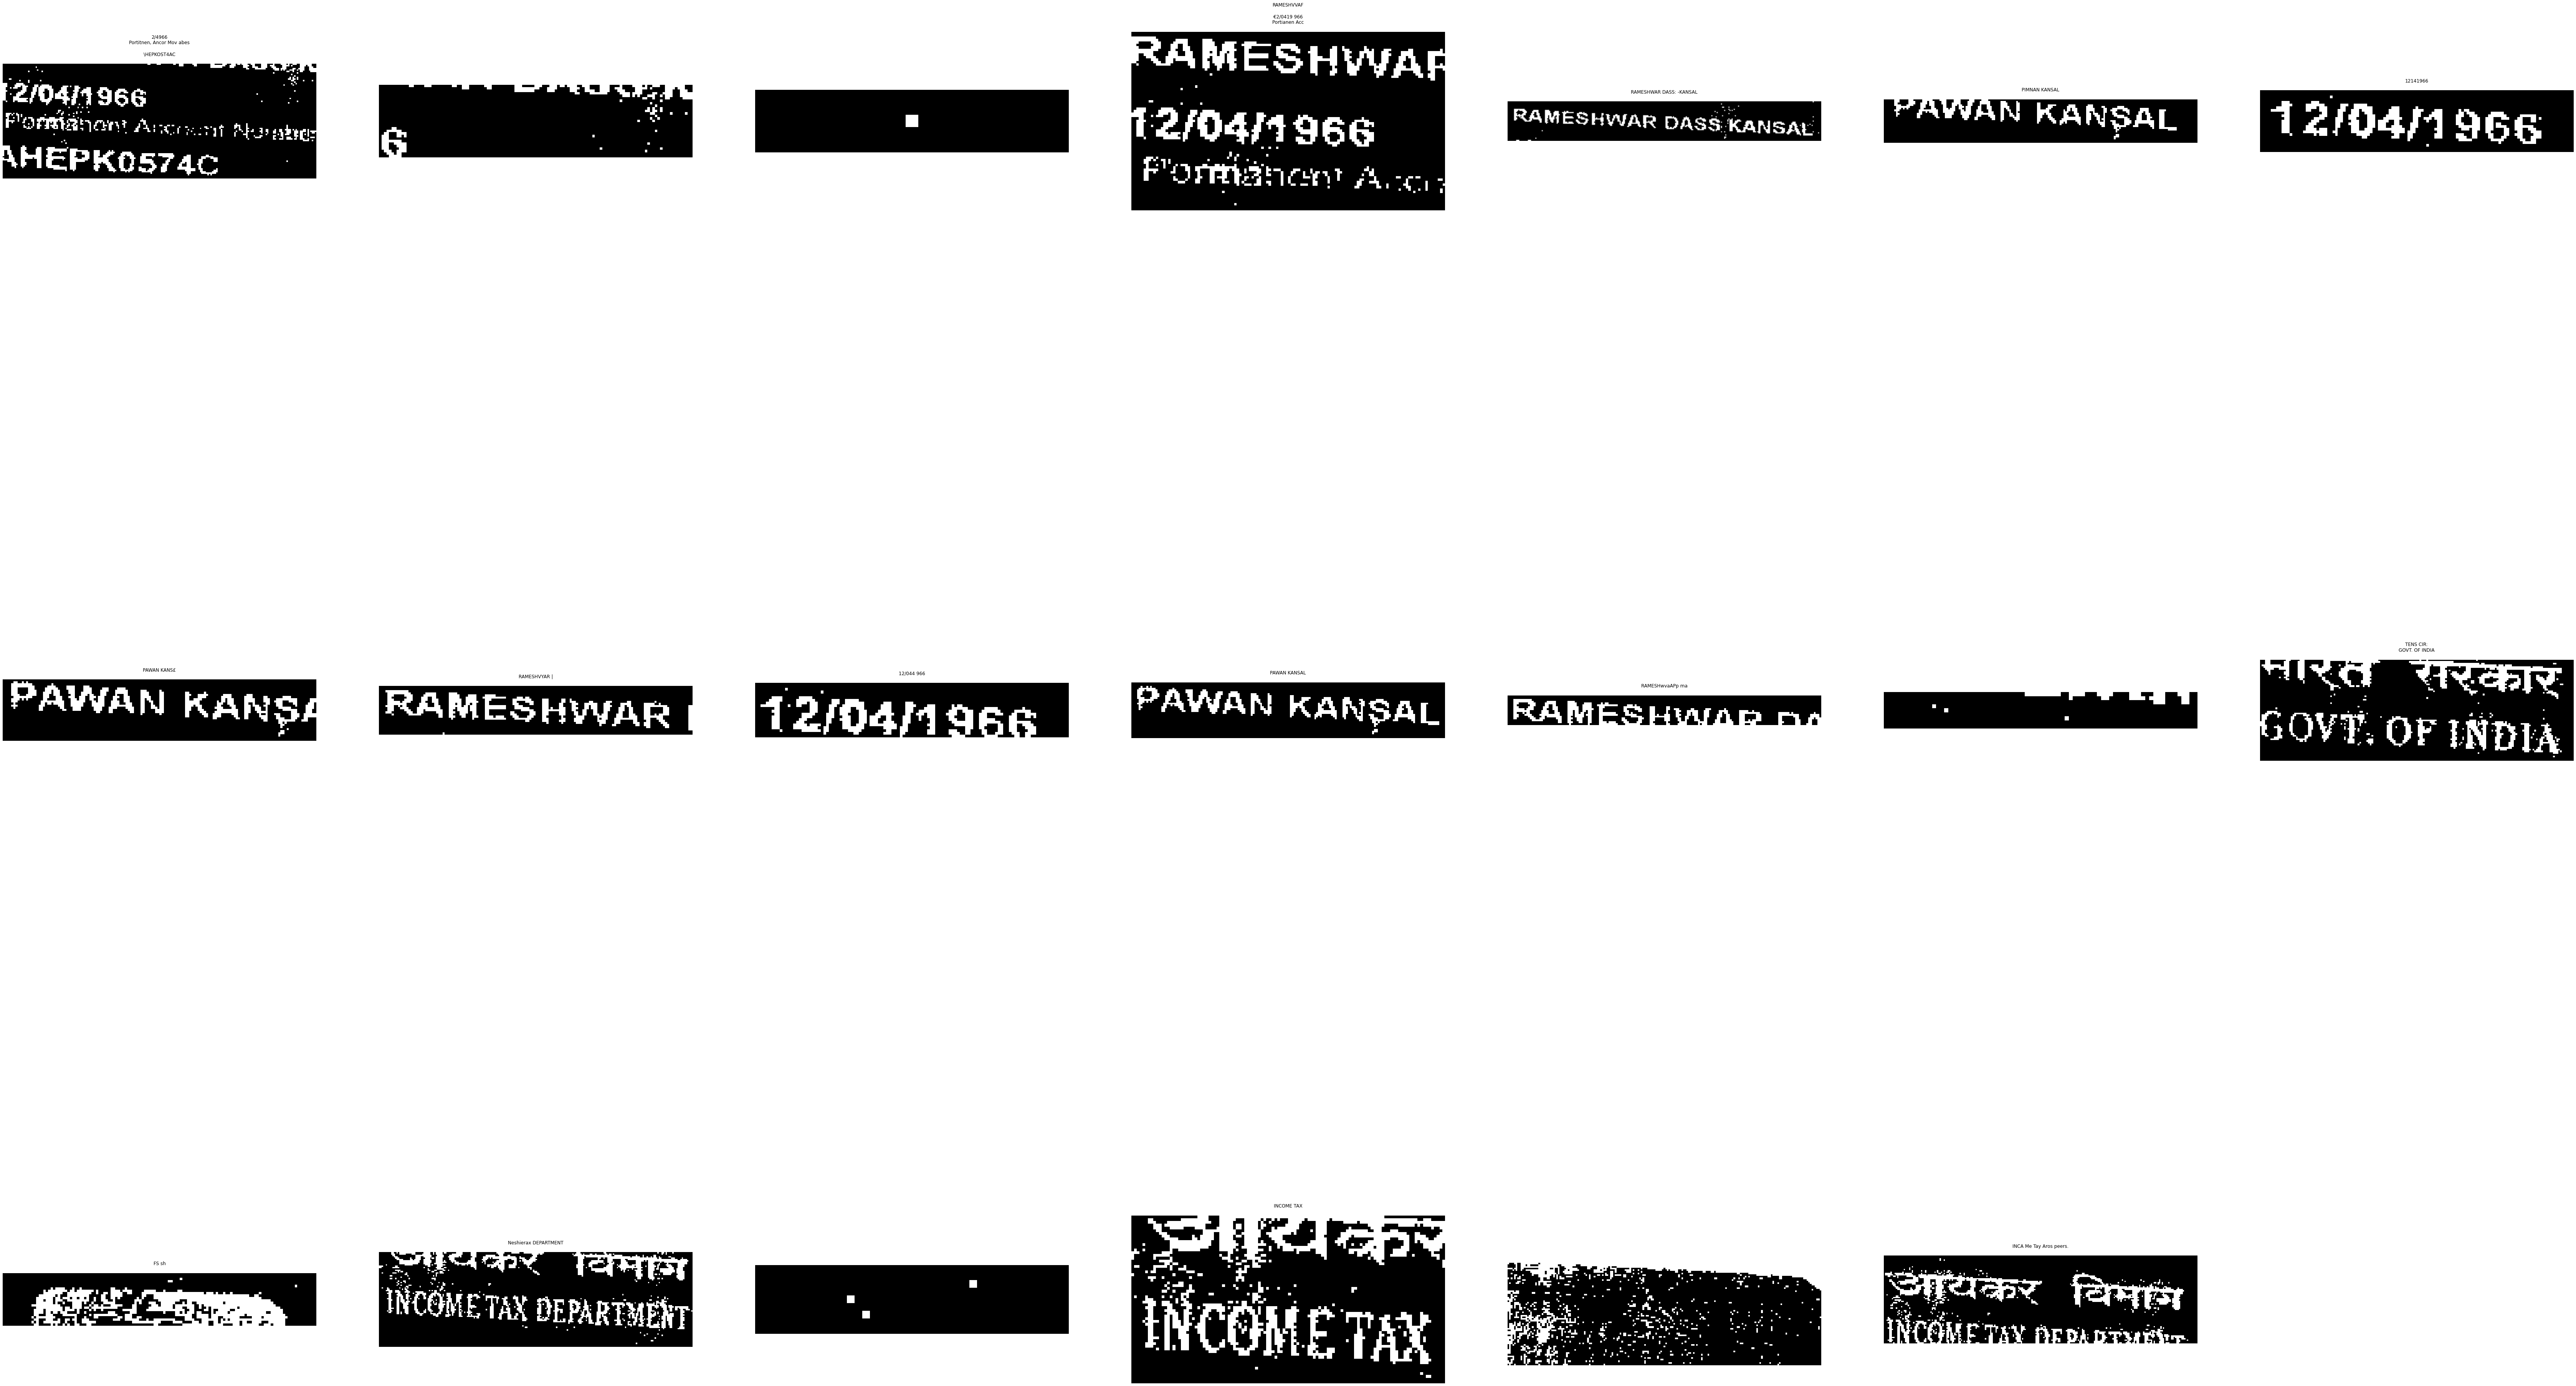

In [22]:
titles = [pytesseract.image_to_string(img) for img in narrowed]
show_images(narrowed, titles=titles, cols=3)

In [23]:
books = load_image("test_1.jpg")
detector = EASTDetector(small_overlap=0.75)
slices = detector.get_slices(books)

In [24]:
# titles = [pytesseract.image_to_string(img, config=custom_config) for img in slices]
# show_images(slices, titles=titles, cols=3)

C:\Users\asus\AppData\Local\Temp/ipykernel_13452/551261532.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


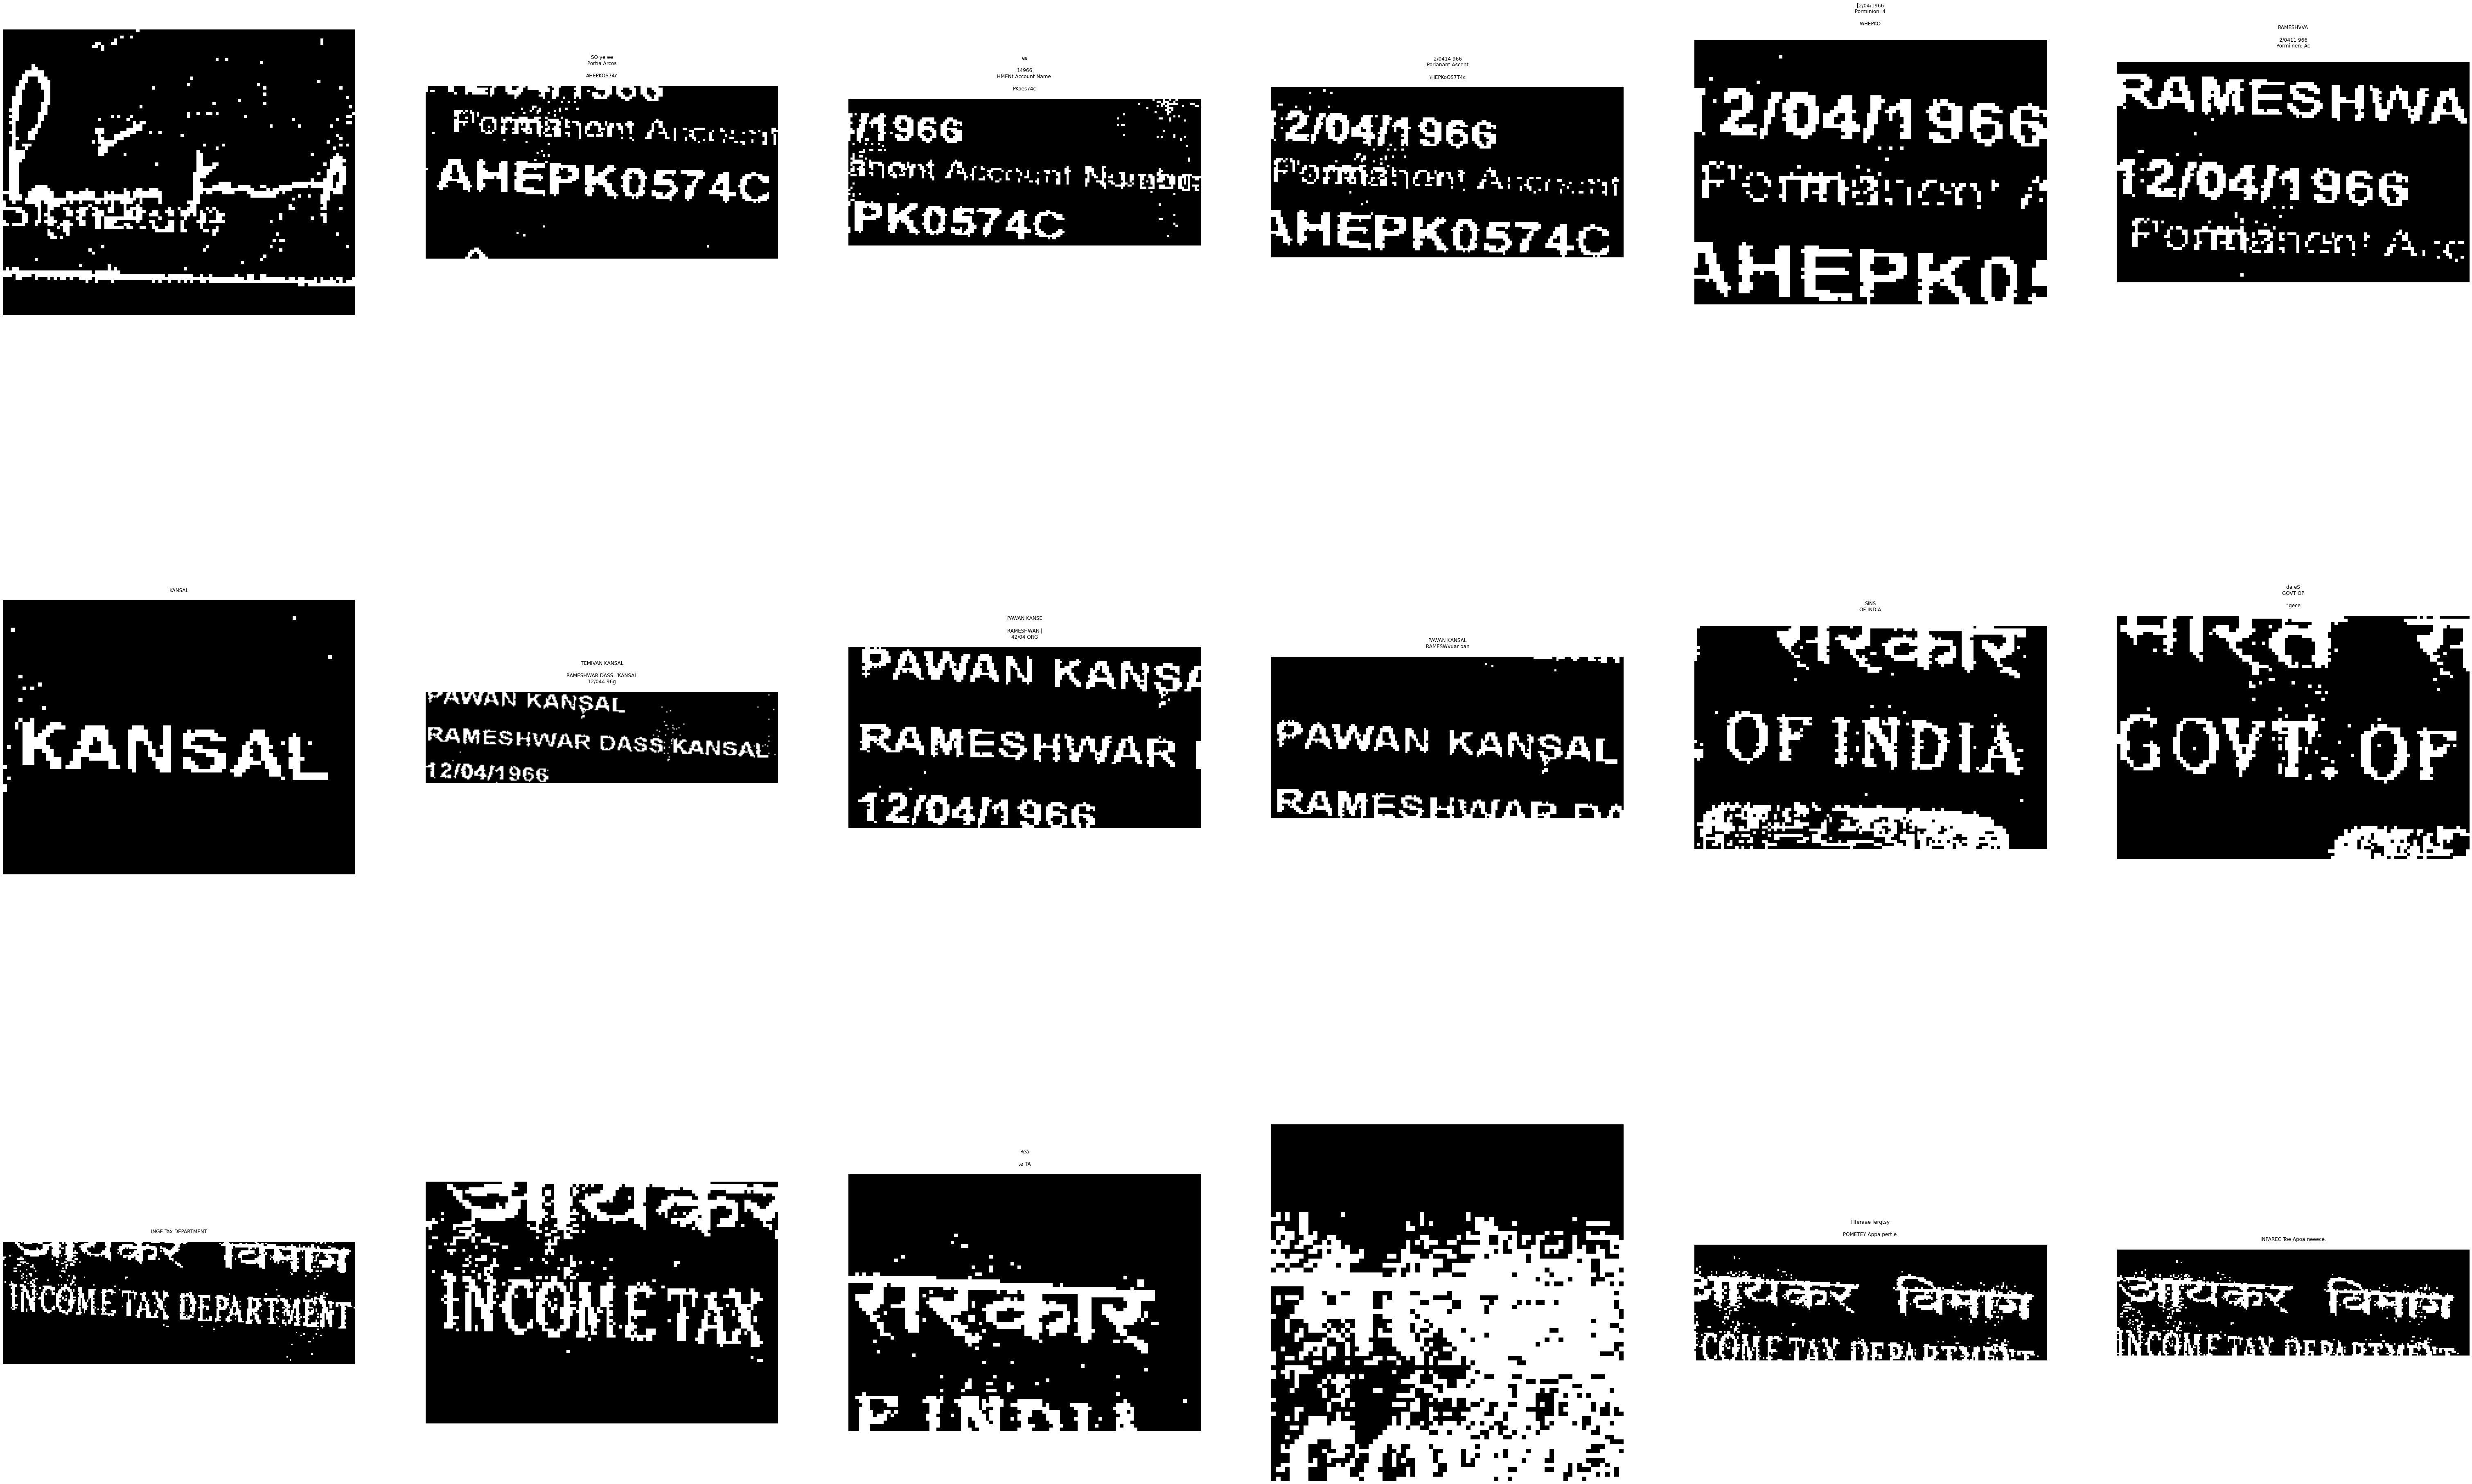

In [25]:
# Binarization
binarized = binarize_images(slices, black_on_white=True)
titles = [pytesseract.image_to_string(img) for img in binarized]
show_images(binarized, titles=titles, cols=3)

C:\Users\asus\AppData\Local\Temp/ipykernel_13452/551261532.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


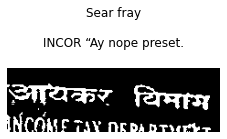

In [26]:
# Blurring
blurred = blur_images([binarized[-1]], blur_weight=3)
titles = [pytesseract.image_to_string(img) for img in blurred]
show_images(blurred, titles=titles, cols=3)

In [27]:
blurred = blur_images([binarized[0]], blur_weight=1)
dilated = dilate_images(blurred, kernel=np.ones((5, 5), np.uint8))

C:\Users\asus\AppData\Local\Temp/ipykernel_13452/551261532.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)


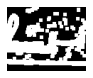

In [28]:
titles = [pytesseract.image_to_string(img) for img in dilated]
show_images(dilated, titles=titles, cols=3)

In [29]:
books = load_image("test_1.jpg")
detector = EASTDetector()
slices = detector.get_slices(books)
img = slices[-1]

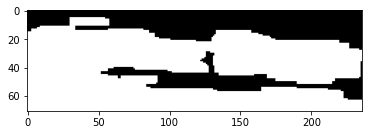

In [30]:
processed = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)           
_, processed = cv2.threshold(processed, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
if np.mean(processed) > 127:
    processed = cv2.bitwise_not(processed)

box_kernel = np.ones((5, 25), np.uint8)
dilation = cv2.dilate(processed, box_kernel, iterations = 1)
bounds, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in bounds:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
    
plt.imshow(dilation, cmap='gray')

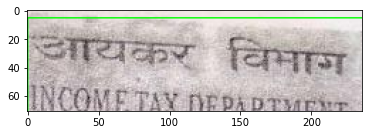

In [31]:
plt.imshow(img)

In [32]:
for i in range(len(slices)):
    img = slices[i]
    print(pytesseract.image_to_string(img, config=custom_config))
    print("===========================")


‘1219411966 2
Portianent Account १९७
AHEPKOS74c

See
210411966

Pepianent Account Nombre:
\HEPKOS574cC

RAMESHWAF
120411966
Poanont Acc

PT AWVAN KANSAL
RAMESHWAR DASS KANSAL
12/04/1966

PAWAN KANS*s
RAMESHWAR |
12/04/1966

PAWAN KANSAL
RAMESHvap nan

UNG NCR
GOVT. OF INDIA
FSS

ry र स्स
11।र्प३क्शा'1त्मा१ DEPARTMENT

Reese
INCOMETAX


Sites fens ET eee Oe

